# <font color='#1a5276'> <b> <center> Regression </center> </b> </font>

## <font color='blue'>  Table of Contents </font>

1. [Introduction](#1)
2. [Setup](#2)
3. [Example 1: Single input, single output](#3) <br>
    3.1. [Helper Functions](#3.1) <br>
    3.2. [Data](#3.2) <br>
    3.3. [Model](#3.3) <br>
    3.4. [Training](#3.4) <br>
    3.5. [Evaluation](#3.5) <br>
    3.6. [Predictions](#3.6) <br>
4. [Example 2: Single input, single output](#4) <br>
    4.1. [Helper Functions](#4.1) <br>
    4.2. [Data](#4.2) <br>
    4.3. [Model](#4.3) <br>
    4.4. [Training](#4.4) <br>
    4.5. [Evaluation](#4.5) <br>
    4.6. [Predictions](#4.6) <br>
5. [Example 3: Multiple predictors](#5) <br>
    5.1. [Helper Functions](#5.1) <br>
    5.2. [Data](#5.2) <br>
    5.3. [Model](#5.3) <br>
    5.4. [Training](#5.4) <br>
6. [Example 4: Multiple outputs](#6) <br>
    6.1. [Helper Functions](#6.1) <br>
    6.2. [Data](#6.2) <br>
    6.3. [Model](#6.3) <br>
    6.4. [Training](#6.4) <br>
    6.5. [Evaluation](#6.5) <br>
7. [Example 5: Logistic Regression, Binary Classification](#7) <br>
    7.1. [Helper Functions](#7.1) <br>
    7.2. [Data](#7.2) <br>
    7.3. [Model](#7.3) <br>
    7.4. [Training](#7.4) <br>
    7.5. [Evaluation](#7.5) <br>
    7.6. [Predictions](#7.6) <br>
8. [Example 6: Logistic Regression, Multiclass classification](#8) <br>
    8.1. [Helper Functions](#8.1) <br>
    8.2. [Data](#8.2) <br>
    8.3. [Model](#8.3) <br>
    8.4. [Training](#8.4) <br>
    8.5. [Predictions](#8.5) <br>
    8.6. [Analysis](#8.6) <br>
9. [References](#references)

<a name="1"></a>
## <font color='blue'> <b> 1. Introduction </b> </font>

This notebook explores various regression problems using PyTorch. We'll cover:

- Single Predictor Regression: Modeling a single input-output relationship.

- Multiple Predictors Regression: Extending to multiple inputs for complex relationships.

- Multiple Outputs Regression: Handling problems with multiple target variables.

- Logistic Regression: Binary classification viewed as a regression task.

Each section includes detailed implementation, from data preparation to model evaluation.

<a name="2"></a>
## <font color='blue'> <b> 2. Setup</b> </font>

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [128]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
import torchvision.transforms as transforms
import torchvision.datasets as dsets

In [3]:
torch.manual_seed(1)

<a name="3"></a>
## <font color='blue'> <b> 3. Example 1: Single Input, Single Output </b> </font>

<a name="3.1"></a>
### <font color='#2874a6'> <b> 3.1. Helper Functions </b> </font>

In [4]:
# Class for plotting error surfaces
class PlotErrorSurfaces(object):
    
    # Constructor: Initializes the object and computes the loss surface
    def __init__(self, w_range, b_range, X, Y, n_samples=30, go=True):
        # Generate evenly spaced values for weights (w) and biases (b)
        W = np.linspace(-w_range, w_range, n_samples)
        B = np.linspace(-b_range, b_range, n_samples)
        
        # Create a grid for weight and bias values
        w, b = np.meshgrid(W, B)    
        
        # Initialize the loss surface (Z) as a 2D array of zeros
        Z = np.zeros((n_samples, n_samples))
        
        # Convert input tensors to numpy arrays for computation
        self.y = Y.numpy()
        self.x = X.numpy()
        
        # Compute the mean squared error (loss) for each combination of w and b
        count1 = 0
        for w1, b1 in zip(w, b):
            count2 = 0
            for w2, b2 in zip(w1, b1):
                Z[count1, count2] = np.mean((self.y - w2 * self.x + b2) ** 2)
                count2 += 1
            count1 += 1
        
        # Store the computed loss surface and grid for later use
        self.Z = Z
        self.w = w
        self.b = b
        
        # Initialize lists to store parameters and loss values during training
        self.W = []
        self.B = []
        self.LOSS = []
        self.n = 0
        
        # If go is True, plot the initial loss surface
        if go:
            plt.figure()
            plt.figure(figsize=(max(7.5, n_samples / 4), max(5, n_samples / 6)))
            
            # Plot the 3D loss surface
            plt.axes(projection='3d').plot_surface(
                self.w, self.b, self.Z, 
                rstride=1, cstride=1, cmap='viridis', edgecolor='none'
            )
            plt.title('Loss Surface')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.show()
            
            # Plot the 2D contour of the loss surface
            plt.figure()
            plt.title('Loss Surface Contour')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.contour(self.w, self.b, self.Z)
            plt.show()
            
    # Setter: Records the parameters and loss value for a given model state
    def set_para_loss(self, model, loss):
        self.n += 1
        self.LOSS.append(loss)
        self.W.append(list(model.parameters())[0].item())  # Weight parameter
        self.B.append(list(model.parameters())[1].item())  # Bias parameter
    
    # Final plot: Displays the loss surface and the parameter trajectory
    def final_plot(self): 
        # Plot the loss surface with the parameter trajectory
        ax = plt.axes(projection='3d')
        ax.plot_wireframe(self.w, self.b, self.Z)
        ax.scatter(self.W, self.B, self.LOSS, c='r', marker='x', s=200, alpha=1)
        
        # Plot the 2D contour with parameter trajectory
        plt.figure()
        plt.contour(self.w, self.b, self.Z)
        plt.scatter(self.W, self.B, c='r', marker='x')
        plt.xlabel('w')
        plt.ylabel('b')
        plt.show()
        
    # Plot the data space and loss surface contour for the current iteration
    def plot_ps(self):
        plt.subplot(121)  # Data space plot
        plt.plot(self.x, self.y, 'ro', label="training points")
        plt.plot(self.x, self.W[-1] * self.x + self.B[-1], label="estimated line")
        plt.xlabel('x')
        plt.ylabel('y')
        plt.ylim((-10, 15))
        plt.title('Data Space Iteration: ' + str(self.n))
        
        plt.subplot(122)  # Loss surface contour plot
        plt.contour(self.w, self.b, self.Z)
        plt.scatter(self.W, self.B, c='r', marker='x')
        plt.title('Loss Surface Contour Iteration: ' + str(self.n))
        plt.xlabel('w')
        plt.ylabel('b')
        plt.show()

        
        
# plot data
def plot_data(dataset, x_label="x", y_label="y", title="Data Plot", show_legend=True, markers=('rx', 'b-'), 
              labels=('y', 'f')):
    """
    Plots the dataset with customizable parameters.
    
    Args:
        dataset (Dataset): The dataset containing x, y, and f values.
        x_label (str): Label for the x-axis. Default is 'x'.
        y_label (str): Label for the y-axis. Default is 'y'.
        title (str): Title of the plot. Default is 'Data Plot'.
        show_legend (bool): Whether to show the legend. Default is True.
        markers (tuple): Tuple containing markers for the y and f plots. Default is ('rx', 'b-').
        labels (tuple): Tuple containing labels for y and f. Default is ('y', 'f').
    """
    plt.plot(dataset.x.numpy(), dataset.y.numpy(), markers[0], label=labels[0])  # Plot noisy observations
    plt.plot(dataset.x.numpy(), dataset.f.numpy(), markers[1], label=labels[1])  # Plot original function
    plt.xlabel(x_label)  # Set x-axis label
    plt.ylabel(y_label)  # Set y-axis label
    plt.title(title)  # Set plot title
    if show_legend:
        plt.legend()  # Show legend if enabled
    plt.show()

<a name="3.2"></a>
### <font color='#2874a6'> <b> 3.2. Data </b> </font>

We will generate synthetic data.

We will aim to estimate a line f. To do this, the simulated data will consist of points from that line with added random noise.

In [5]:
class Data(Dataset):
    """
    Custom Dataset class to generate and provide synthetic data for regression tasks.
    
    The dataset represents a simple linear function y = 1*x - 1 with added Gaussian noise.
    
    Attributes:
        x (torch.Tensor): Input tensor containing evenly spaced values in the range [-3, 3).
        f (torch.Tensor): The noiseless linear function to be estimated (1*x - 1).
        y (torch.Tensor): Noisy observations generated by adding Gaussian noise to `f`.
        len (int): The number of data points in the dataset.
    """
    
    # Constructor: Initializes the dataset by generating input, function, and noisy observations
    def __init__(self):
        # Generate evenly spaced values in the range [-3, 3) with a step of 0.1
        self.x = torch.arange(-3, 3, 0.1).view(-1, 1) 
        
        # Define the linear function to estimate: f(x) = 1*x - 1
        self.f = 1 * self.x - 1 
        
        # Add Gaussian noise to the function to generate noisy observations
        self.y = self.f + 0.1 * torch.randn(self.x.size()) 
        
        # Store the number of data points
        self.len = self.x.shape[0]
        
    # Getter: Retrieves a single data point (x, y) at the given index
    def __getitem__(self, index):    
        return self.x[index], self.y[index]
    
    # Get Length: Returns the total number of data points in the dataset
    def __len__(self):
        return self.len


In [6]:
# create a dataset object
dataset = Data()

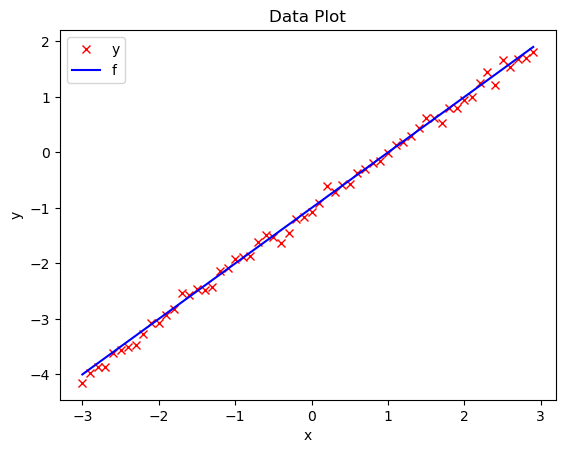

In [7]:
# plot data
plot_data(dataset, labels=('y', 'f'))

In [8]:
# Create Dataloader object
train_loader = DataLoader(dataset = dataset, batch_size = 1)

In [9]:
# Create plot surface object
get_surface = PlotErrorSurfaces(15, 13, dataset.x, dataset.y, 30, go = False)

<a name="3.3"></a>
### <font color='#2874a6'> <b> 3.3. Model </b> </font>

In [10]:
# Define the Linear Regression model by extending nn.Module
class linear_regression(nn.Module):
    
    # Constructor: Initializes the model
    def __init__(self, input_size, output_size):
        # Call the constructor of the parent class (nn.Module)
        super(linear_regression, self).__init__()
        # Define a single linear layer: y = Wx + b
        self.linear = nn.Linear(input_size, output_size)
        
    # Forward method: Defines how the input data is transformed into output
    def forward(self, x):
        # Apply the linear transformation (Wx + b) to the input x
        yhat = self.linear(x)
        return yhat  # Return the predicted output

In [11]:
# Build in cost function
criterion = nn.MSELoss()

In [12]:
# create an object linear regression
model = linear_regression(1, 1)

In [13]:
# create an object optimizer (note that it uses the previous object)
optimizer = optim.SGD(model.parameters(), lr = 0.01)

Note that to create an optimizer, you must provide an iterable containing the parameters, i.e., you should pass <code>model.parameters()</code> as input to the constructor.

In [14]:
list(model.parameters())

[Parameter containing:
 tensor([[0.3636]], requires_grad=True),
 Parameter containing:
 tensor([0.4957], requires_grad=True)]

The previous output represents the parameters of a PyTorch `nn.Linear` layer, which are typically the **weights** and **biases** of the linear transformation. Here's a detailed breakdown:

---

#### **What the Output Means**
1. **`Parameter containing`**:
   - This indicates that the tensors are PyTorch `Parameter` objects. A `Parameter` is a special kind of tensor used by `nn.Module`.
   - Unlike regular tensors, parameters are automatically registered as part of the model and have the attribute `requires_grad=True` by default, meaning they will be updated during training via backpropagation.

2. **`tensor([[0.3636]], requires_grad=True)`**:
   - This is the **weight matrix** of the `nn.Linear` layer.
   - The value `0.3636` is the initialized weight for the linear transformation.
   - The shape of the tensor is `(1, 1)` because the `nn.Linear` layer was created with `input_size=1` and `output_size=1`.

3. **`tensor([0.4957], requires_grad=True)`**:
   - This is the **bias term** of the `nn.Linear` layer.
   - The value `0.4957` is the initialized bias for the linear transformation.
   - The shape of the tensor is `(1,)` because there is one bias term per output neuron, and here there is only one output.

---

#### **Context: `nn.Linear` Transformation**
For an `nn.Linear` layer, the transformation is mathematically represented as:

\[
y = Wx + b
\]

Where:
- \( W \) is the weight matrix (tensor `[[ 0.3636 ]]`).
- \( b \) is the bias vector (tensor `[ 0.4957 ]`).
- \( x \) is the input tensor.
- \( y \) is the output tensor.

---

#### **Why `requires_grad=True`?**
- These parameters are marked with `requires_grad=True` because they are trainable.  
- During training, the gradients of the loss with respect to these parameters will be computed, and their values will be updated by the optimizer.

---

#### **How It Relates to Training**
1. **Initialization**: PyTorch initializes weights and biases with small random values (or according to a specific initialization strategy).
2. **Optimization**: During training, these parameters are updated to minimize the loss function using methods like gradient descent.
3. **Accessing Parameters**: You can view and access these parameters using:
   ```python
   print(model.linear.weight)  # Outputs the weight tensor
   print(model.linear.bias)    # Outputs the bias tensor


In [15]:
# Retrieve the current state of the optimizer, including parameter values and optimization settings
optimizer.state_dict()

{'state': {},
 'param_groups': [{'lr': 0.01,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'maximize': False,
   'foreach': None,
   'differentiable': False,
   'fused': None,
   'params': [0, 1]}]}

PyTorch initializes the parameters of the model. In this very simple example, if we use those parameters, the result won't be very insightful, as the convergence will happen very quickly. So, we will initialize them in a way that makes the convergence take longer.

In [16]:
# Customize the weight and bias
model.state_dict()['linear.weight'][0] = -15
model.state_dict()['linear.bias'][0] = -10

In [17]:
list(model.parameters())

[Parameter containing:
 tensor([[-15.]], requires_grad=True),
 Parameter containing:
 tensor([-10.], requires_grad=True)]

<a name="3.4"></a>
### <font color='#2874a6'> <b> 3.4. Training </b> </font>

In [18]:
# Define the function to train the model
def train_model(model, train_loader, criterion, optimizer, epochs):
    # Loop through the number of iterations (epochs)
    for epoch in range(epochs):
        # Loop through the training data (train_loader)
        for x, y in train_loader:
            # Forward pass: Predict using the model
            yhat = model(x)
            
            # Calculate the loss between the predicted and true values
            loss = criterion(yhat, y)
            
            # Log the loss for tracking (assumed function to track loss)
            get_surface.set_para_loss(model, loss.tolist())
            
            # Zero the gradients before the backward pass
            optimizer.zero_grad()
            
            # Backward pass: Compute the gradient of the loss with respect to model parameters
            loss.backward()
            
            # Update the model parameters using the optimizer
            optimizer.step()
        
        # Plot the loss or surface after each epoch (assumed function for visualization)
        get_surface.plot_ps()
        
    # return trained model
    return model


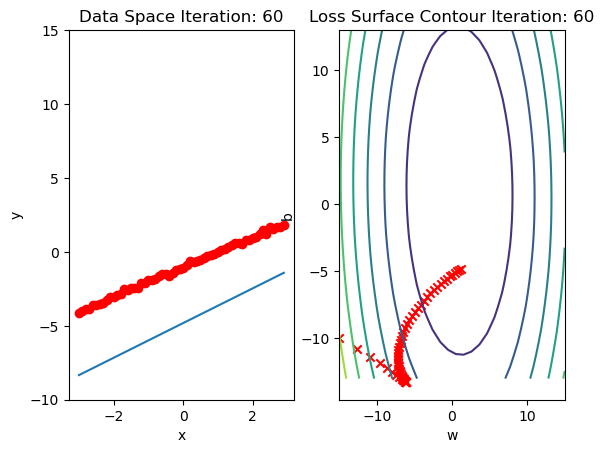

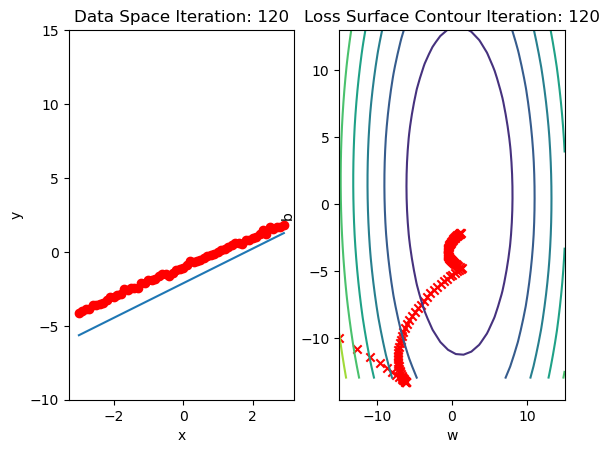

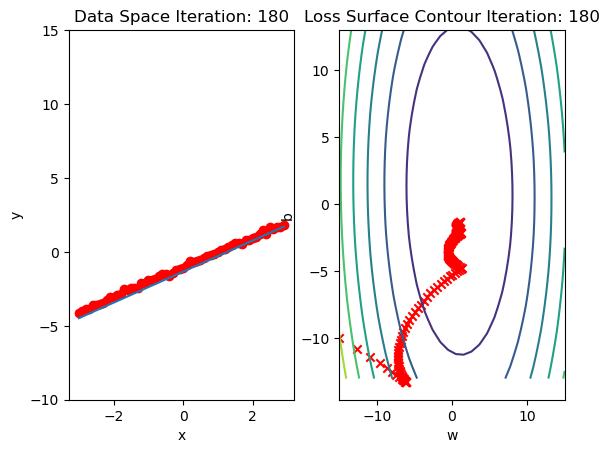

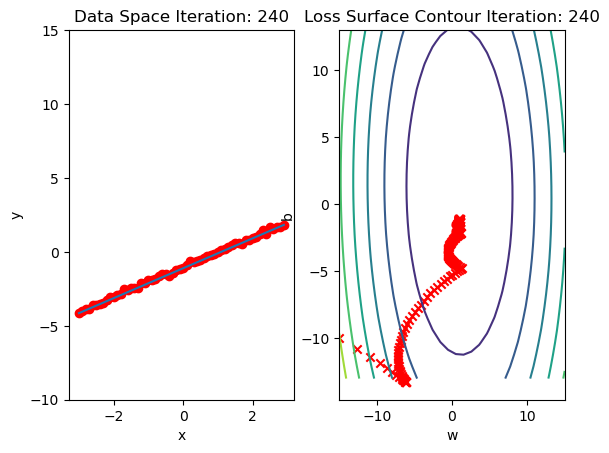

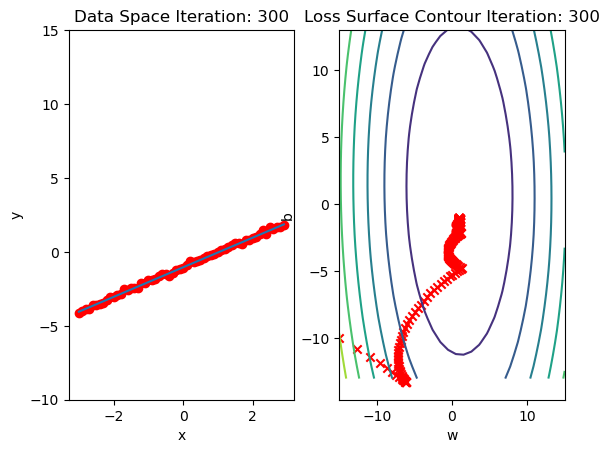

In [19]:
trained_model = train_model(model, train_loader, criterion, optimizer, 5)

In [20]:
model.state_dict()

OrderedDict([('linear.weight', tensor([[0.9984]])),
             ('linear.bias', tensor([-1.0432]))])

In [21]:
trained_model.state_dict()

OrderedDict([('linear.weight', tensor([[0.9984]])),
             ('linear.bias', tensor([-1.0432]))])

Note that PyTorch modifies the model passed as a parameter because the model's parameters (weights and biases) are updated in place during training. This behavior is intentional and aligns with PyTorch's design philosophy, where models are trained by adjusting their parameters based on the gradients calculated during the backpropagation process. Therefore, it is normal and desirable for train_model to modify the passed model object.

However, if you do not want to modify the original model, you can create a deep copy of the model before training to preserve the original state:

```
import copy

def train_model(model, train_loader, criterion, optimizer, epochs):
    # Create a copy of the model to avoid modifying the original
    model = copy.deepcopy(model)
```

<a name="3.5"></a>
### <font color='#2874a6'> <b> 3.5. Evaluation </b> </font>

In [22]:
# function to evaluate the model
def evaluate_model(model, dataset, criterion):
    """
    Evaluates the model on the provided dataset using the specified loss function (criterion).
    
    Args:
        model (torch.nn.Module): The model to be evaluated.
        dataset (DataLoader): The DataLoader object that provides the batches of data.
        criterion (torch.nn.Module): The loss function to calculate the error.
    
    Returns:
        float: The average loss over all batches in the dataset.
    """
    
    total_loss = 0.0  # Initialize variable to accumulate the loss over all batches
    num_batches = 0  # Initialize counter for the number of batches
    
    # Set the model to evaluation mode
    model.eval()
    
    # Disable gradient calculation to save memory and computation during evaluation
    with torch.no_grad():
        # Loop through the dataset in batches
        for x_batch, y_batch in dataset:
            # Get model predictions
            y_hat = model(x_batch)
            
            # Calculate the loss between predicted and true values
            loss = criterion(y_hat, y_batch)
            
            # Accumulate the total loss (average batch loss)
            total_loss += loss.item()
            
            # Increment the batch counter
            num_batches += 1
    
    # Calculate the average loss by dividing total loss by number of batches
    average_loss = total_loss / num_batches
    
    return average_loss  # Return the average loss


In [23]:
# simulate a val dataset
val_dataset = Data()
val_loader = DataLoader(dataset = dataset, batch_size = 1)

In [24]:
# evaluate
loss = evaluate_model(model, val_loader, criterion)
loss

0.008324531212353273

<a name="3.6"></a>
### <font color='#2874a6'> <b> 3.6. Predictions </b> </font>

In [25]:
# make predictions
def predict(model, data):
    """
    Function to make predictions using the trained model.
    
    Parameters:
    - model: The trained model.
    - data: A list of input data (can be a list of numbers or features).
    
    Returns:
    - predictions: A list of predicted values.
    """
    # Convert the input data to a tensor
    data_tensor = torch.tensor(data, dtype=torch.float32)
    
    # Put the model in evaluation mode
    model.eval()

    # List to store predictions
    predictions = []

    # Make predictions without batching
    with torch.no_grad():  # Disable gradient computation
        for x in data_tensor:
            # Get predictions from the model
            y_hat = model(x.unsqueeze(0))  # Add batch dimension (unsqueeze)
            
            # Append the prediction to the list
            predictions.append(y_hat.item())  # Convert tensor to a scalar value

    return predictions

In [26]:
input_data = [1.0, 2.0, 3.0, 4.0]  # List of input data (e.g., features)
predictions = predict(model, input_data)

print(predictions)

[-0.04487740993499756, 0.9534827470779419, 1.9518429040908813, 2.9502029418945312]


Considering that the true values (with the true line being \( y = x - 1 \)) for the input \([1, 2, 3, 4]\) are \([0, 1, 2, 3]\), we can see that our model does a good job.

<a name="4"></a>
## <font color='blue'> <b> 4. Example 2: Single Input, Single Output </b> </font>

<a name="4.1"></a>
### <font color='#2874a6'> <b> 4.1. Helper Functions </b> </font>

In [27]:
# plot data
def plot_data(dataset):
    plt.plot(dataset.x.numpy(), dataset.y.numpy(), 'xr',label="training data ")
    plt.plot(dataset.x.numpy(), dataset.f.numpy(),label="true function  ")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()
    

# plot errors
def plot_errors(train_errors, val_errors):
    plt.semilogx(np.array(learning_rates), train_errors.numpy(), label = 'training loss/total Loss')
    plt.semilogx(np.array(learning_rates), val_errors.numpy(), label = 'validation cost/total Loss')
    plt.ylabel('Cost\ Total Loss')
    plt.xlabel('learning rate')
    plt.legend()
    plt.show()

<a name="4.2"></a>
### <font color='#2874a6'> <b> 4.2. Data </b> </font>

The following class will include the option to produce training or validation data. The training data will include outliers.

In [28]:
# Define a custom dataset class inheriting from PyTorch's Dataset class
class Data(Dataset):
    
    # Constructor: Initializes the dataset
    def __init__(self, train=True):
        # Generate input data: x values in the range [-3, 3) with step 0.1, reshaped to column vector
        self.x = torch.arange(-3, 3, 0.1).view(-1, 1)
        
        # Define the true function: f = -3x + 1
        self.f = -3 * self.x + 1
        
        # Add some noise to the output values, creating the noisy y values
        self.y = self.f + 0.1 * torch.randn(self.x.size())
        
        # Store the length of the dataset (number of samples)
        self.len = self.x.shape[0]
        
        # Introduce outliers if the dataset is for training
        if train:
            # Set the first data point as an outlier (y[0] = 0)
            self.y[0] = 0
            
            # Set a range of values as outliers (y[50:55] = 20)
            self.y[50:55] = 20
        else:
            # No modifications for the validation dataset
            pass
      
    # Getter: Return a specific data point at the given index
    def __getitem__(self, index):    
        return self.x[index], self.y[index]
    
    # Get Length: Return the number of data points in the dataset
    def __len__(self):
        return self.len


We will create 2 objects: one for training and one for validation.

In [29]:
train_data = Data()
val_data = Data(train = False)

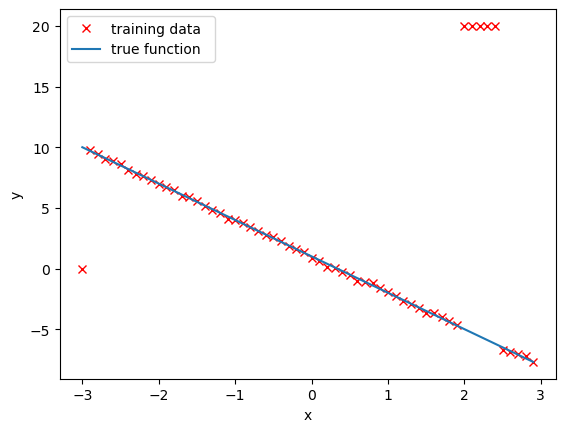

In [30]:
# plot trainig data and true function
plot_data(train_data)

In the above plot we can see the presence of the outliers in the training data.

In [31]:
# DataLoader
train_loader = DataLoader(dataset = train_data, batch_size = 1)

<a name="4.3"></a>
### <font color='#2874a6'> <b> 4.3. Model </b> </font>

In [32]:
# Create Linear Regression Class
class linear_regression(nn.Module):
    """
    A simple linear regression model using PyTorch's nn.Module.
    
    Attributes:
        linear (nn.Linear): A linear layer that transforms input data to output predictions.

    Methods:
        forward(x): Performs the forward pass through the network, returning predicted values.
    """
    
    # Constructor
    def __init__(self, input_size, output_size):
        """
        Initializes the linear regression model with a linear layer.
        
        Args:
            input_size (int): The number of features in the input data.
            output_size (int): The number of output values (predictions).
        """
        super(linear_regression, self).__init__()
        # Define the linear transformation from input_size to output_size
        self.linear = nn.Linear(input_size, output_size)
    
    # Prediction
    def forward(self, x):
        """
        Performs the forward pass to make predictions.
        
        Args:
            x (Tensor): The input data to pass through the network.
        
        Returns:
            Tensor: The predicted output after applying the linear layer.
        """
        # Apply the linear layer to the input data
        yhat = self.linear(x)
        return yhat


In [33]:
# Create MSELoss function
criterion = nn.MSELoss()

<a name="4.4"></a>
### <font color='#2874a6'> <b> 4.4. Training </b> </font>

In [34]:
# we will try different learning rates
learning_rates = [0.0001, 0.001, 0.01, 0.1]

In [35]:
def train_models(train_loader, train_data, val_data, iter, lr_list):
    """
    Trains multiple linear regression models with different learning rates and evaluates them on 
    training and validation datasets.

    Args:
    - train_loader: DataLoader containing the training data in batches.
    - train_data: Dataset containing the training data (features and labels).
    - val_data: Dataset containing the validation data (features and labels).
    - iter: Number of iterations (epochs) for training each model.
    - lr_list: List of learning rates to be tested.

    Returns:
    - models: List of trained models corresponding to each learning rate.
    - train_error: Tensor containing the training error for each model.
    - validation_error: Tensor containing the validation error for each model.
    """
    
    # to store the train error for each model (one model per learning rate)
    train_error = torch.zeros(len(lr_list))

    # to store the validation error for each model
    validation_error = torch.zeros(len(lr_list))
    
    # to store the different models
    models = []
    
    # iterate through the different learning rates
    for i, lr in enumerate(lr_list):
        # Initialize the model with 1 input and 1 output
        model = linear_regression(1, 1)
        
        # Initialize the optimizer with the current learning rate
        optimizer = optim.SGD(model.parameters(), lr=lr)
        
        # Train the model for a specified number of iterations (epochs)
        for epoch in range(iter):
            for x, y in train_loader:  # we train only with the training data
                # Perform a forward pass
                yhat = model(x)
                
                # Compute the loss (difference between predicted and true values)
                loss = criterion(yhat, y)
                
                # Zero the gradients before performing backpropagation
                optimizer.zero_grad()
                
                # Backward pass: compute the gradients
                loss.backward()
                
                # Update the model parameters using the optimizer
                optimizer.step()
        
        # After training, evaluate the model on the training data
        yhat = model(train_data.x)
        train_loss = criterion(yhat, train_data.y)
        train_error[i] = train_loss.item()
        
        # Evaluate the model on the validation data
        yhat = model(val_data.x)
        val_loss = criterion(yhat, val_data.y)
        validation_error[i] = val_loss.item()
        
        # Save the trained model
        models.append(model)

    return models, train_error, validation_error


In [36]:
res_models, res_train_error , res_val_error = train_models(train_loader, train_data, val_data, 10, learning_rates)

Note that the length of res_train_error and res_val_error is 4, with each element corresponding to the error obtained for each learning rate.

In [37]:
res_train_error.shape, res_val_error.shape

(torch.Size([4]), torch.Size([4]))

<a name="4.5"></a>
### <font color='#2874a6'> <b> 4.5. Evaluation </b> </font>

We will plot the training and validation loss for each model.

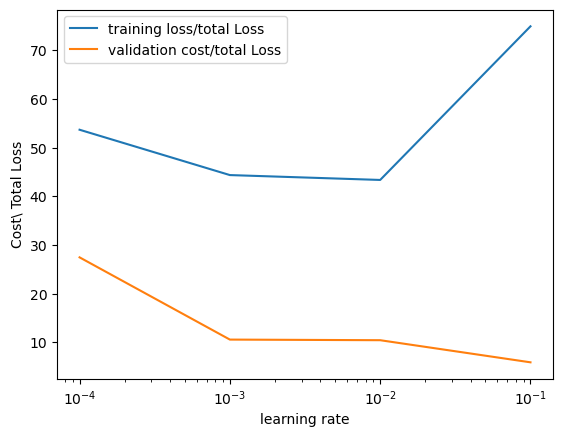

In [38]:
plot_errors(res_train_error, res_val_error)

<a name="4.6"></a>
### <font color='#2874a6'> <b> 4.6. Predictions </b> </font>

We will make predictions for each model.

i [[0.62602574]
 [0.62785846]
 [0.6296912 ]]
i [[5.466408]
 [5.34835 ]
 [5.230292]]
i [[6.5574474]
 [6.4240456]
 [6.2906427]]
i [[14.521047]
 [14.083524]
 [13.646   ]]


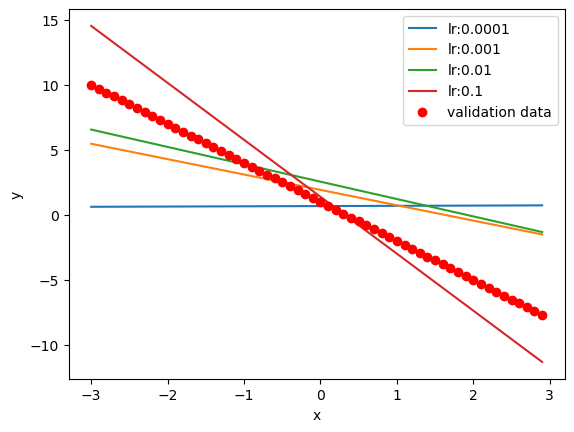

In [39]:
def make_predictions(models, learning_rates):
    # Initialize index for iteration
    i = 0

    # Iterate through the models and their corresponding learning rates
    for model, learning_rate in zip(models, learning_rates):
        # Make predictions (yhat) using the model on the validation data features (val_data.x)
        yhat = model(val_data.x)

        # Plot the predictions (yhat) against the validation data features (val_data.x)
        # .detach() is used to remove the tensor from the computation graph for visualization
        # .numpy() converts the tensor to a numpy array for plotting
        plt.plot(val_data.x.numpy(), yhat.detach().numpy(), label='lr:' + str(learning_rate))

        # Print the first 3 predicted values for debugging purposes
        print('i', yhat.detach().numpy()[0:3])

    # Plot the actual validation data (f) as red circles ('or')
    # This shows the true values of the validation data for comparison
    plt.plot(val_data.x.numpy(), val_data.f.numpy(), 'or', label='validation data')

    # Add labels for the x-axis and y-axis
    plt.xlabel('x')
    plt.ylabel('y')

    # Display a legend that shows the learning rates for each model
    plt.legend()

    # Show the plot
    plt.show()
    
    
make_predictions(res_models, learning_rates)

<a name="5"></a>
## <font color='blue'> <b> 5. Example 3: Multiple Predictors </b> </font>


Unlike our previous work with a single predictor, we now consider multiple input variables, each contributing to the prediction of the target variable. This shift introduces new opportunities and challenges, as we move from fitting a simple line to fitting a higher-dimensional hyperplane.

<a name="5.1"></a>
### <font color='#2874a6'> <b> 5.1. Helper Functions </b> </font>

In [40]:
# The function for plotting 2D
def Plot_2D_Plane(model, dataset, n=0):
    # Extract weights and bias from the model's state dictionary
    w1 = model.state_dict()['linear.weight'].numpy()[0][0]  # Weight for the first predictor
    w2 = model.state_dict()['linear.weight'].numpy()[0][1]  # Weight for the second predictor
    b = model.state_dict()['linear.bias'].numpy()          # Bias term

    # Extract data points from the dataset
    x1 = dataset.x[:, 0].view(-1, 1).numpy()  # Values for the first predictor
    x2 = dataset.x[:, 1].view(-1, 1).numpy()  # Values for the second predictor
    y = dataset.y.numpy()                     # Target values

    # Create a mesh grid to generate the plane
    X, Y = np.meshgrid(np.arange(x1.min(), x1.max(), 0.05), np.arange(x2.min(), x2.max(), 0.05))
    yhat = w1 * X + w2 * Y + b  # Compute predictions for the plane

    # Create a 3D plot
    fig = plt.figure()
    ax = plt.axes(projection='3d')  # Use plt.axes() to create 3D axes

    # Plot the data points as red circles
    ax.plot(x1[:, 0], x2[:, 0], y[:, 0], 'ro', label='y')  # Scatter plot for data points
    
    # Plot the estimated plane
    ax.plot_surface(X, Y, yhat)  # Surface plot for the regression plane
    
    # Label the axes
    ax.set_xlabel('x1 ')  # Label for the first predictor
    ax.set_ylabel('x2 ')  # Label for the second predictor
    ax.set_zlabel('y')    # Label for the target variable
    
    # Add a title with the iteration number
    plt.title('Estimated plane iteration:' + str(n))
    
    # Add a legend
    ax.legend()

    # Display the plot
    plt.show()


<a name="5.2"></a>
### <font color='#2874a6'> <b> 5.2. Data </b> </font>

We will create synthetic data.

In [41]:
class Data2D(Dataset):
    
    # Constructor
    def __init__(self):
        # Initialize input features as a 20x2 tensor
        self.x = torch.zeros(20, 2)
        self.x[:, 0] = torch.arange(-1, 1, 0.1)  # Fill the first column with values from -1 to 1
        self.x[:, 1] = torch.arange(-1, 1, 0.1)  # Fill the second column with the same range

        # Define the true weights and bias for the linear function
        self.w = torch.tensor([[1.0], [1.0]])  # True weights for both predictors
        self.b = 1                            # True bias term

        # Compute the ideal output (without noise) based on the linear equation
        self.f = torch.mm(self.x, self.w) + self.b

        # Add random noise to the ideal output to create target values
        self.y = self.f + 0.1 * torch.randn((self.x.shape[0], 1))  # Adding Gaussian noise

        # Store the number of data points
        self.len = self.x.shape[0]
        
    # Getter
    def __getitem__(self, index):
        # Return the feature vector and corresponding target value for the given index
        return self.x[index], self.y[index]

    # Get Length
    def __len__(self):
        # Return the number of data points in the dataset
        return self.len


In [42]:
# Create the dataset object
dataset = Data2D()

In [43]:
# shape
dataset.x.shape, dataset.y.shape

(torch.Size([20, 2]), torch.Size([20, 1]))

We can see that we have a dataset with 20 samples, 2 input features, and 1 output feature.

In [44]:
# Create the data loader
train_loader = DataLoader(dataset=dataset, batch_size=2)

<a name="5.3"></a>
### <font color='#2874a6'> <b> 5.3. Model </b> </font>

In [45]:
# Model definition
class linear_regression(nn.Module):
    
    # constructor
    def __init__(self, input_size, output_size):
        super(linear_regression, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    # prediction
    def forward(self, x):
        return self.linear(x)

In [46]:
# Create the linear regression model and print the parameters
model = linear_regression(2, 1) # 2 inputs and 1 output
print("The parameters: ", list(model.parameters()))

The parameters:  [Parameter containing:
tensor([[-0.6954,  0.4065]], requires_grad=True), Parameter containing:
tensor([0.0498], requires_grad=True)]


In [47]:
# Create the cost function
criterion = nn.MSELoss()

In [48]:
# Create the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.1)

<a name="5.4"></a>
### <font color='#2874a6'> <b> 5.4. Training </b> </font>

We will train using the gradient descent algorithm and store the cost for each iteration. Remember that this is actually an approximation of the true cost.

In [49]:
def train(train_loader, epochs):
    """
    Train the model using data from the provided data loader.

    Args:
        train_loader (DataLoader): DataLoader for the training dataset.
        epochs (int): Number of epochs to train the model.

    Returns:
        list: A list containing the loss value for each iteration.
    """
    
    # Initialize a list to store loss values for each iteration
    loss_results = []
    
    # Iterate through the specified number of epochs
    for epoch in range(epochs):
        # Loop through the batches of data in the train_loader
        for x, y in train_loader:
            # Compute the model's prediction
            yhat = model(x)
            # Calculate the loss between prediction and true values
            loss = criterion(yhat, y)
            # Append the current loss value to the results list
            loss_results.append(loss.item())
            # Reset the gradients of the optimizer
            optimizer.zero_grad()
            # Compute gradients for all model parameters
            loss.backward()
            # Update model parameters using the optimizer
            optimizer.step()
            
    # Return the list of loss values
    return loss_results


Before Training: 


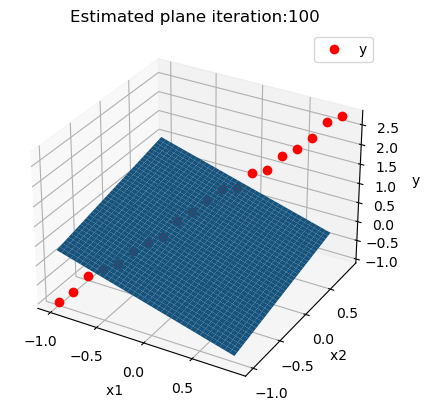

In [50]:
print("Before Training: ")
Plot_2D_Plane(model, dataset, 100) 

In [51]:
# train
loss_results = train(train_loader, 100)

After Training: 


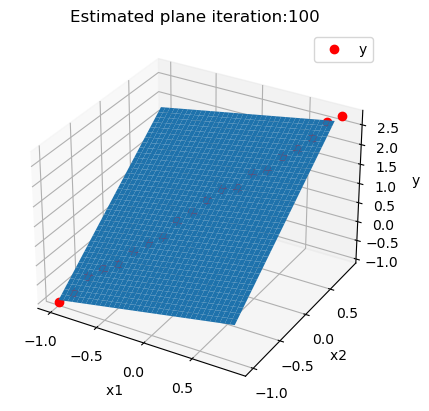

In [52]:
print("After Training: ")
Plot_2D_Plane(model, dataset, 100) 

<a name="6"></a>
## <font color='blue'> <b> 6. Example 4: Multiple Outputs </b> </font>


Having previously implemented linear regression for scenarios involving a single output—both with one and multiple predictors—this extension will handle cases where the model predicts multiple outputs simultaneously. The project aims to deepen understanding of PyTorch’s flexibility in modeling and optimizing linear regression systems with multi-dimensional output spaces.

<a name="6.1"></a>
### <font color='#2874a6'> <b> 6.1. Helper Functions </b> </font>

In [75]:
# plot data
def plot_data(data, title, xlabel, ylabel):
    plt.plot(data)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

<a name="6.2"></a>
### <font color='#2874a6'> <b> 6.2. Data </b> </font>

In [53]:
# Define a custom Dataset class
class Data(Dataset):
    def __init__(self):
        # Initialize the feature tensor with zeros of shape (20, 2)
        self.x = torch.zeros(20, 2)
        
        # Set the first column of x with values ranging from -1 to 0.9 (step 0.1)
        self.x[:, 0] = torch.arange(-1, 1, 0.1)
        
        # Set the second column of x with random noise added to the ascending range
        self.x[:, 1] = torch.arange(-1, 1, 0.1) + 0.1 * torch.randn(20)
        
        # Define a weight matrix (2x2) for the linear relationship
        self.w = torch.tensor([[1.0, -1.0], [1.0, 3.0]])
        
        # Define a bias term (1x2) for the linear relationship
        self.b = torch.tensor([[1.0, -1.0]])
        
        # Calculate the linear transformation: f = x * w + b
        self.f = torch.mm(self.x, self.w) + self.b
        
        # Add Gaussian noise to the target values to simulate real-world data
        self.y = self.f + 0.001 * torch.randn((self.x.shape[0], 1))
        
        # Store the number of data points
        self.len = self.x.shape[0]

    # Method to retrieve a single data point (features and target)
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    # Method to get the total number of data points in the dataset
    def __len__(self):
        return self.len


In [54]:
# create a Data object
dataset = Data()

Let's inspect the data a little bit.

In [56]:
# let's see a couple of items
print(dataset[0])  # Calls dataset.__getitem__(0), returns values of x and y
print(dataset[7])

(tensor([-1.0000, -1.0035]), tensor([-1.0019, -3.0089]))
(tensor([-0.3000, -0.2993]), tensor([ 0.4018, -1.5968]))


In [57]:
aux = dataset[1]
type(aux) # tuple: self.x[index], self.y[index] 

tuple

In [58]:
print(type(dataset[0][0]))  # This is the type of self.x[index], which is a tensor
print(type(dataset[0][1]))  # This is the type of self.y[index], which is also a tensor>

<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [59]:
print(dataset[0][0])
print(dataset[0][1])

tensor([-1.0000, -1.0035])
tensor([-1.0019, -3.0089])


In [60]:
print(f"Shape of the input: {dataset[0][0].shape}")
print(f"Shape of the output: {dataset[0][1].shape}")

Shape of the input: torch.Size([2])
Shape of the output: torch.Size([2])


DataLoader

In [61]:
# train loader
train_loader = DataLoader(dataset=dataset, batch_size = 5)

<a name="6.3"></a>
### <font color='#2874a6'> <b> 6.3. Model </b> </font>

In [62]:
# model architecture
class linear_regression(nn.Module):
    
    # constructor
    def __init__(self, input_size, output_size):
        super(linear_regression, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    # predictions
    def forward(self, x):
        yhat = self.linear(x)
        return yhat

In [63]:
# model object
model = linear_regression(2, 2)

In [64]:
# criterion
criterion = nn.MSELoss()

In [65]:
# optimizer
optimizer = optim.SGD(model.parameters(), lr = 0.1)

<a name="6.4"></a>
### <font color='#2874a6'> <b> 6.4. Training </b> </font>

In [67]:
def train(model, train_loader, criterion, optimizer, epochs=50):
    
    # to store average loss per epoch
    loss_results = []
    
    for epoch in range(epochs):
        epoch_loss = 0.0 # variable to accumulate loss for this epoch
        
        for x, y in train_loader:
            # make a prediction
            yhat = model(x)
            
            # calculate the loss
            loss = criterion(yhat, y)
            
            # accumulate the loss for averaging later
            epoch_loss += loss.item()
            
            # clear gradients
            optimizer.zero_grad()
            
            # backward pass: compute gradients of the loss
            loss.backward()
            
            # update model parameters
            optimizer.step()
            
        # store the average loss for the epoch
        avg_epoch_loss = epoch_loss / len(train_loader)
        loss_results.append(avg_epoch_loss)
        
    return model, loss_results

In [69]:
trained_model, loss_results = train(model, train_loader, criterion, optimizer)

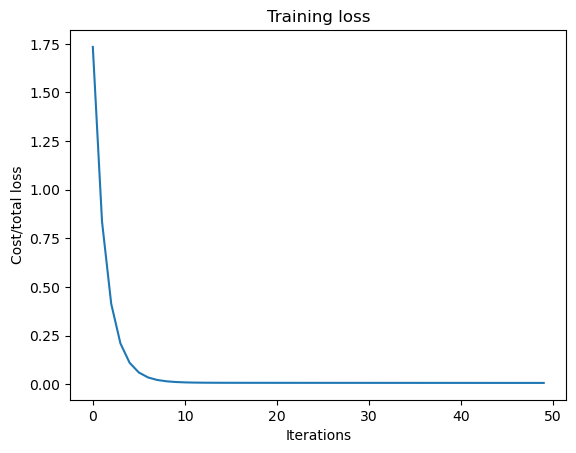

In [76]:
# plot loss
plot_data(loss_results, "Training loss", "Iterations", "Cost/total loss")

<a name="6.5"></a>
### <font color='#2874a6'> <b> 6.5. Predictions </b> </font>

In [79]:
# trained model
model.eval()  # Set the model to evaluation mode

# Input data
x = torch.tensor([[1.0, 2.0]])

print(f"Shape of x: {x.shape}")

# Make predictions
with torch.no_grad():  # Disable gradient calculation
    yhat = model(x)  # Pass input through the model to get predictions

print(f'Predicted Output: {yhat}')

Shape of x: torch.Size([1, 2])
Predicted Output: tensor([[3.9213, 2.5998]])


In [80]:
# Example batch of input data (x) - let's say it has 10 samples, each with 2 features
x_batch = torch.tensor([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0], 
                       [7.0, 8.0], [9.0, 10.0], [11.0, 12.0],
                       [13.0, 14.0], [15.0, 16.0], [17.0, 18.0], [19.0, 20.0]])


print(f"Shape of the batch: {x_batch.shape}")

# Make predictions for the entire batch
with torch.no_grad():
    yhat_batch = model(x_batch)

print(f'Predicted Output for the Batch: {yhat_batch}')

Shape of the batch: torch.Size([10, 2])
Predicted Output for the Batch: tensor([[ 3.9213,  2.5998],
        [ 7.9249,  6.6566],
        [11.9285, 10.7134],
        [15.9321, 14.7701],
        [19.9358, 18.8269],
        [23.9394, 22.8837],
        [27.9430, 26.9405],
        [31.9466, 30.9973],
        [35.9502, 35.0541],
        [39.9538, 39.1108]])


<a name="7"></a>
## <font color='blue'> <b> 7. Example 5: Logistic Regression, Binary classification </b> </font>

A binary classification problem is a type of machine learning task where the goal is to classify data into one of two distinct categories or classes. In logistic regression, the model learns to predict a label based on input features, and the output is a probability that reflects the likelihood of belonging to one of the two classes. Instead of simply classifying data as "spam" or "not spam," for example, the model provides a probability value that represents the likelihood of an email being spam.

For example, in a spam email classification problem, the task is to predict whether an email is spam or not, but instead of a hard "yes" or "no," the model outputs a probability. This probability can then be used to make a decision, such as classifying the email as spam if the probability exceeds a certain threshold.

Similarly, in medical diagnostics, a model might predict the probability that a patient has a certain disease, based on their medical data. The model will not just say "yes" or "no," but rather provide a probability value, such as a 70% likelihood of having the disease.

In this section, we will solve the binary classification problem using logistic regression, which outputs a probability that can be used for classification. This model maps the input features to a value between 0 and 1, representing the probability of one of the classes (e.g., spam or not spam). By choosing an appropriate threshold, we can classify the data into the two categories.


<a name="7.1"></a>
### <font color='#2874a6'> <b> 7.1. Helper Functions </b> </font>

In [120]:
# Create class for plotting and the function for plotting
class PlotErrorSurfaces(object):
    
    # Constructor to initialize parameters and compute the error surface
    def __init__(self, w_range, b_range, X, Y, n_samples = 30, go = True):
        # Generate linearly spaced values for weights (w) and biases (b)
        W = np.linspace(-w_range, w_range, n_samples)
        B = np.linspace(-b_range, b_range, n_samples)
        
        # Create a meshgrid for w and b
        w, b = np.meshgrid(W, B)    
        
        # Initialize a zero matrix for storing the error values (Z)
        Z = np.zeros((30, 30))
        count1 = 0
        
        # Convert X and Y to numpy arrays
        self.y = Y.numpy()
        self.x = X.numpy()
        
        # Loop through all combinations of weights (w2) and biases (b2)
        for w1, b1 in zip(w, b):
            count2 = 0
            for w2, b2 in zip(w1, b1):
                # Compute the predicted values using the sigmoid function
                yhat = 1 / (1 + np.exp(-1 * (w2 * self.x + b2)))
                
                # Compute the loss (binary cross-entropy) and store it in Z
                Z[count1, count2] = -1 * np.mean(self.y * np.log(yhat + 1e-16) + (1 - self.y) * np.log(1 - yhat + 1e-16))
                count2 += 1   
            count1 += 1
        
        # Store the computed error surface (Z) and parameters (w, b)
        self.Z = Z
        self.w = w
        self.b = b
        
        # Initialize empty lists for storing the weight, bias, and loss values
        self.W = []
        self.B = []
        self.LOSS = []
        self.n = 0
        
        # If 'go' is True, plot the 3D surface and contour of the loss surface
        if go == True:
            plt.figure()
            plt.figure(figsize=(7.5, 5))
            plt.axes(projection='3d').plot_surface(self.w, self.b, self.Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
            plt.title('Loss Surface')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.show()
            plt.figure()
            plt.title('Loss Surface Contour')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.contour(self.w, self.b, self.Z)
            plt.show()
            
    # Method to set the model's parameters and record the loss
    def set_para_loss(self, model, loss):
        self.n = self.n + 1
        self.W.append(list(model.parameters())[0].item())  # Store weight
        self.B.append(list(model.parameters())[1].item())  # Store bias
        self.LOSS.append(loss)  # Store loss
    
    # Plot final error surface and contour with model parameters
    def final_plot(self): 
        ax = plt.axes(projection='3d')
        ax.plot_wireframe(self.w, self.b, self.Z)  # Plot the 3D wireframe
        ax.scatter(self.W, self.B, self.LOSS, c='r', marker='x', s=200, alpha=1)  # Plot the parameter values with loss
        plt.figure()
        plt.contour(self.w, self.b, self.Z)  # Plot the 2D contour
        plt.scatter(self.W, self.B, c='r', marker='x')  # Plot the parameter values on the contour
        plt.xlabel('w')
        plt.ylabel('b')
        plt.show()
        
    # Plot the data space and loss surface contour for each iteration
    def plot_ps(self):
        plt.subplot(121)
        plt.ylim  # Set the y-axis limits
        plt.plot(self.x, self.y, 'ro', label="training points")  # Plot training data
        plt.plot(self.x, self.W[-1] * self.x + self.B[-1], label="estimated line")  # Plot the estimated line
        plt.plot(self.x, 1 / (1 + np.exp(-1 * (self.W[-1] * self.x + self.B[-1]))), label='sigmoid')  # Plot sigmoid function
        plt.xlabel('x')
        plt.ylabel('y')
        plt.ylim((-0.1, 2))
        plt.title('Data Space Iteration: ' + str(self.n))  # Title showing current iteration
        plt.show()
        plt.subplot(122)
        plt.contour(self.w, self.b, self.Z)  # Plot the loss surface contour
        plt.scatter(self.W, self.B, c='r', marker='x')  # Plot the model parameters on the contour
        plt.title('Loss Surface Contour Iteration' + str(self.n))  # Title showing current iteration
        plt.xlabel('w')
        plt.ylabel('b')
        
# Function to plot the model predictions and loss surface
def PlotStuff(X, Y, model, epoch, leg=True):
    plt.plot(X.numpy(), model(X).detach().numpy(), label=('epoch ' + str(epoch)))  # Plot model predictions
    plt.plot(X.numpy(), Y.numpy(), 'r')  # Plot true values
    if leg == True:
        plt.legend()  # Add a legend if 'leg' is True
    else:
        pass

    
# plot data
def plot_data(dataset):
    # Extract data points and labels
    x_data = dataset.x.numpy().flatten()  # Convert tensor to numpy array
    y_data = dataset.y.numpy().flatten()  # Convert tensor to numpy array

    # Plotting
    plt.scatter(x_data[y_data == 0], y_data[y_data == 0], color='blue', label='Class 0')
    plt.scatter(x_data[y_data == 1], y_data[y_data == 1], color='red', label='Class 1')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Data Visualization')
    plt.legend()
    plt.grid(True)
    plt.show()


<a name="7.2"></a>
### <font color='#2874a6'> <b> 7.2. Data </b> </font>

In [93]:
# Create the data class
class Data(Dataset):
    
    # Constructor
    def __init__(self):
        self.x = torch.arange(-1, 1, 0.1).view(-1, 1)
        self.y = torch.zeros(self.x.shape[0], 1)
        self.y[self.x[:, 0] > 0.2] = 1
        self.len = self.x.shape[0]
    
    # Getter
    def __getitem__(self, index):      
        return self.x[index], self.y[index]
    
    # Get length
    def __len__(self):
        return self.len

In [94]:
# create an object
dataset = Data()

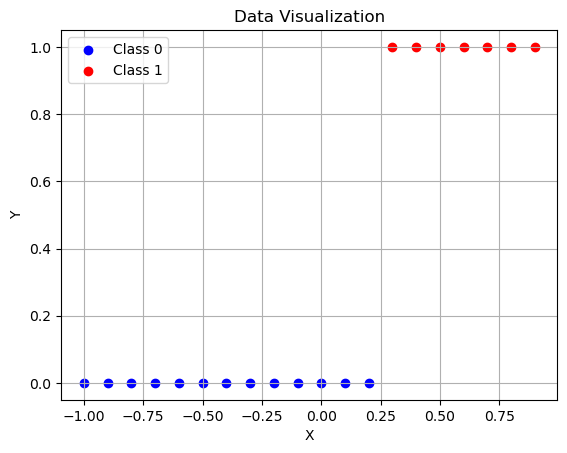

In [121]:
# plot dataset
plot_data(dataset)

<Figure size 640x480 with 0 Axes>

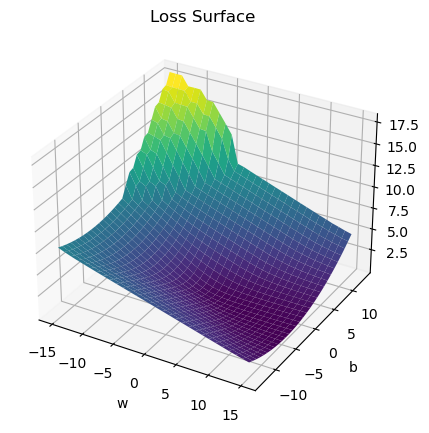

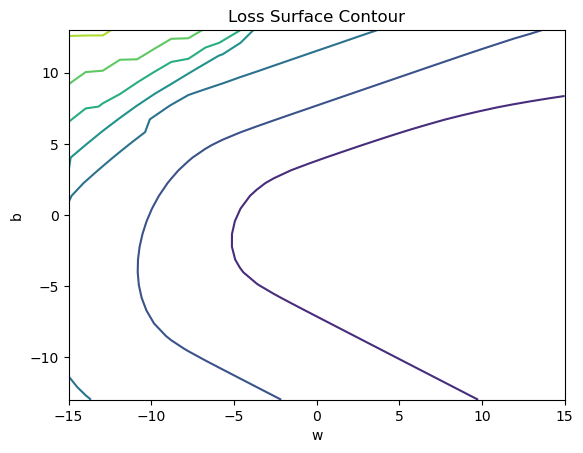

In [95]:
# Create the plot_error_surfaces object
get_surface = PlotErrorSurfaces(15, 13, dataset[:][0], dataset[:][1], 30)

In [87]:
# train loader
trainloader = DataLoader(dataset = dataset, batch_size = 3)

<a name="7.3"></a>
### <font color='#2874a6'> <b> 7.3. Model </b> </font>

In [97]:
# Logistic Regression class
class LogisticRegression(nn.Module):
    
    # constructor
    def __init__(self, n_inputs):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(n_inputs, 1)
        
    # prediction
    def forward(self, x):
        yhat = torch.sigmoid(self.linear(x)) # now we include a sigmoid in the output
        return yhat


In [98]:
# Create the model
model = LogisticRegression(1)

In [99]:
# Set the weight and bias
model.state_dict()['linear.weight'].data[0] = torch.tensor([[-5]])
model.state_dict()['linear.bias'].data[0] = torch.tensor([[-10]])
print("The parameters: ", model.state_dict())

The parameters:  OrderedDict([('linear.weight', tensor([[-5.]])), ('linear.bias', tensor([-10.]))])


Criterion function implemented from scratch to practice.

In [100]:
# criterion: Binary crossentropy loss
def criterion(yhat, y):
    """
    Computes the Binary Cross-Entropy (BCE) loss.
    
    Formula:
        Loss = -1/N * sum(y_i * log(yhat_i) + (1 - y_i) * log(1 - yhat_i))
    
    Args:
        yhat (torch.Tensor): Predicted probabilities, values between 0 and 1 (shape: [N]).
        y (torch.Tensor): Ground truth labels, values 0 or 1 (shape: [N]).
    
    Returns:
        torch.Tensor: The mean binary cross-entropy loss.
    
    Notes:
        - This implementation assumes yhat is already a probability (sigmoid applied).
        - For numerical stability, yhat values are clamped to avoid log(0).
    """
    # Clamp yhat to avoid log(0) issues
    yhat = torch.clamp(yhat, min=1e-7, max=1 - 1e-7)
    # Compute the binary cross-entropy loss
    return -torch.mean(y * torch.log(yhat) + (1 - y) * torch.log(1 - yhat))


In [101]:
# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = 2)

<a name="7.4"></a>
### <font color='#2874a6'> <b> 7.4. Training </b> </font>

In [102]:
# train function
def train_model(model, trainloader, criterion, optimizer, epochs):
    for epoch in range(epochs):
        for x, y in trainloader:
            yhat = model(x)
            loss = criterion(yhat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            get_surface.set_para_loss(model, loss.tolist())
        
        if epoch % 20 == 0:
            get_surface.plot_ps()
            
    return model

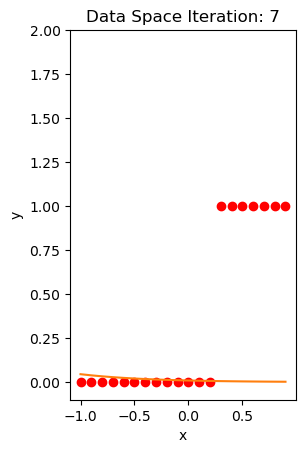

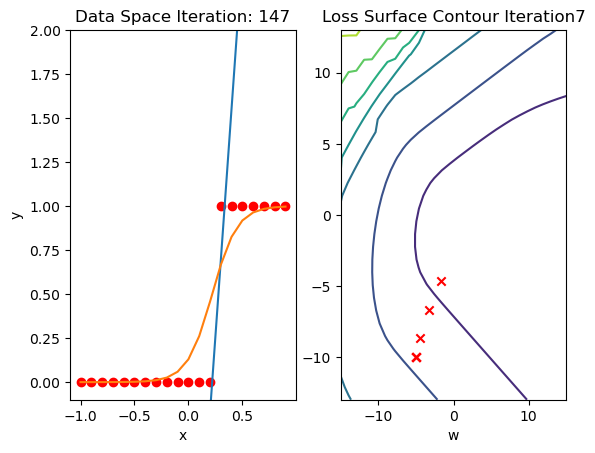

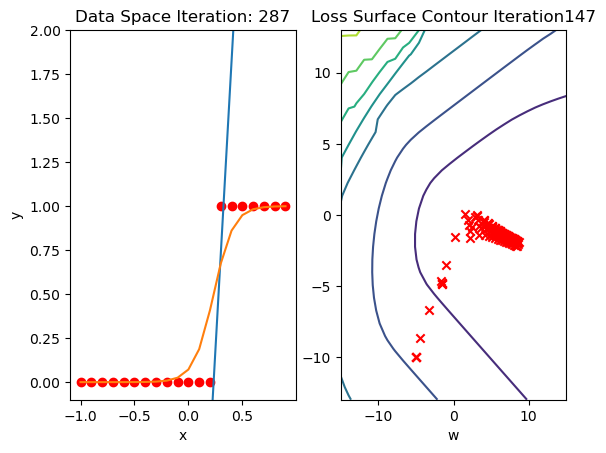

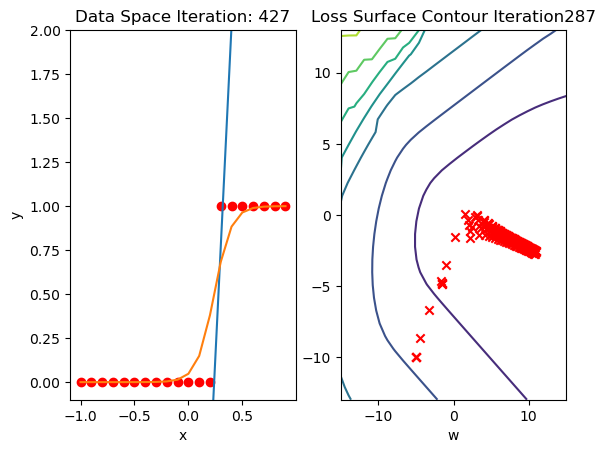

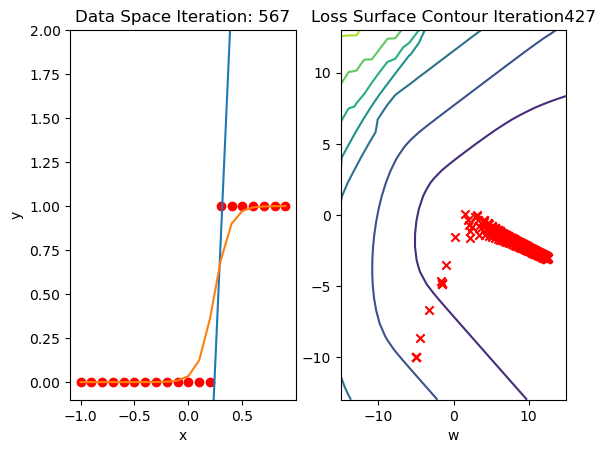

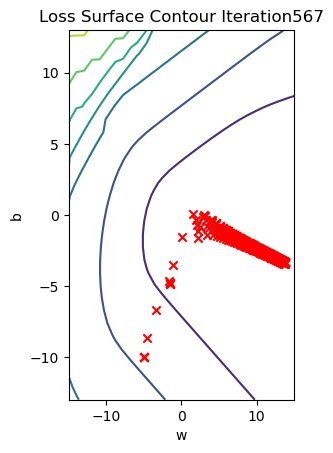

In [103]:
trained_model = train_model(model, trainloader, criterion, optimizer, 100)

<a name="7.5"></a>
### <font color='#2874a6'> <b> 7.5. Evaluation </b> </font>

In [104]:
# Evaluation function
def evaluate_model(model, dataset, threshold=0.5):
    # Set the model to evaluation mode
    model.eval()
    
    # Disable gradient calculations during evaluation for efficiency
    with torch.no_grad():
        # Make predictions
        yhat = model(dataset.x)
        
        # Convert probabilities to labels based on the threshold
        label = yhat > threshold
        
        # Calculate accuracy
        accuracy = torch.mean((label == dataset.y.type(torch.ByteTensor)).type(torch.float))
    
    return accuracy

In [105]:
# simulate a validation set
val_dataset = Data()

In [106]:
accuracy = evaluate_model(trained_model, val_dataset)    
print(f"Accuracy: {accuracy}")    

Accuracy: 1.0


<a name="7.6"></a>
### <font color='#2874a6'> <b> 7.6. Predictions </b> </font>

In [110]:
dataset.x[7]

tensor([-0.3000])

In [116]:
trained_model.eval()

x1 = torch.tensor([.4]) 

yhat1 = trained_model(x1)

print(f"Pred: {yhat1}")

Pred: tensor([0.9116], grad_fn=<SigmoidBackward0>)


In [122]:
x1 = torch.tensor([.12]) 

yhat1 = trained_model(x1)

print(f"Pred: {yhat1}")

Pred: tensor([0.1385], grad_fn=<SigmoidBackward0>)


<a name="8"></a>
## <font color='blue'> <b> 8. Example 6: Logistic Regression, Multiclass classification </b> </font>

In a binary classification task, the goal is to categorize data into one of two classes, often labeled as 0 or 1. For example, predicting whether an email is spam (1) or not spam (0).

In a multiclass classification task, the goal is to classify data into one of three or more classes. Unlike binary classification, where the model only chooses between two categories, multiclass classification involves more than two possible outcomes. For instance, predicting which type of fruit is shown in an image could involve classes like "apple," "banana," or "cherry."

In this example, we are going to work with the MNIST dataset, which consists of handwritten digits (0-9). The goal is to classify each image into one of these 10 classes. While binary classification uses a simple decision boundary, multiclass classification typically employs techniques like one-vs-rest or softmax to handle multiple classes. The evaluation metrics also expand to handle the complexity of multiple classes, such as using accuracy, precision, recall, or F1 score across all classes.

<a name="8.1"></a>
### <font color='#2874a6'> <b> 8.1. Helper Functions </b> </font>

In [154]:
# plot parameters
def plot_parameters(model): 
    # Get the weights of the linear layer from the model (assuming a model with a 'linear' layer).
    W = model.state_dict()['linear.weight'].data
    
    # Find the minimum and maximum values of the weight matrix to normalize the colormap.
    w_min = W.min().item()
    w_max = W.max().item()
    
    # Create a 2x5 grid of subplots for displaying 10 images (28x28 each).
    fig, axes = plt.subplots(2, 5)
    
    # Adjust space between subplots for better readability.
    fig.subplots_adjust(hspace=0.01, wspace=0.1)
    
    # Loop through the axes and plot the corresponding weight values as images.
    for i, ax in enumerate(axes.flat):
        if i < 10:  # Only plot the first 10 classes (0-9).
            
            # Set the label for the subplot with the corresponding class number.
            ax.set_xlabel("class: {0}".format(i))

            # Reshape the weights of each class (flattened 28x28) into a 28x28 image and plot it.
            ax.imshow(W[i, :].view(28, 28), vmin=w_min, vmax=w_max, cmap='seismic')

            # Remove the x and y axis ticks for better visualization.
            ax.set_xticks([])
            ax.set_yticks([])

    # Display the plot.
    plt.show()

    

# show data
def show_data(data_sample):
    # Reshape the data sample (assumed to be a 1D tensor of length 784) into a 28x28 image and display it.
    # Convert the tensor to a NumPy array and reshape it to 28x28 for visualization.
    plt.imshow(data_sample[0].numpy().reshape(28, 28), cmap='gray')

    # Set the title of the plot to display the label of the data sample.
    # 'data_sample[1]' is assumed to be the label (e.g., 0-9 for MNIST)
    plt.title('y = ' + str(data_sample[1]))
    
    # Show the plot
    plt.show()

    
# plot loss
def plot_loss(data, title, xlabel, ylabel):
    plt.plot(data)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

<a name="8.2"></a>
### <font color='#2874a6'> <b> 8.2. Data </b> </font>

We will use the MNIST data.

In [130]:
# load train dataset
train_dataset = dsets.MNIST(root='./', train=True, download=True, transform=transforms.ToTensor())
print("Print the training dataset:\n ", train_dataset)

Print the training dataset:
  Dataset MNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train
    StandardTransform
Transform: ToTensor()


In [132]:
# Create and print the validating dataset
validation_dataset = dsets.MNIST(root='./', download=True, transform=transforms.ToTensor())
print("Print the validating dataset:\n ", validation_dataset)

Print the validating dataset:
  Dataset MNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train
    StandardTransform
Transform: ToTensor()


Let's explore the data a little bit:

In [134]:
# Print the shape of train dataset
train_dataset[0][0].shape

torch.Size([1, 28, 28])

In [135]:
# Print the label
print("Label: ", train_dataset[5][1])

Label:  2


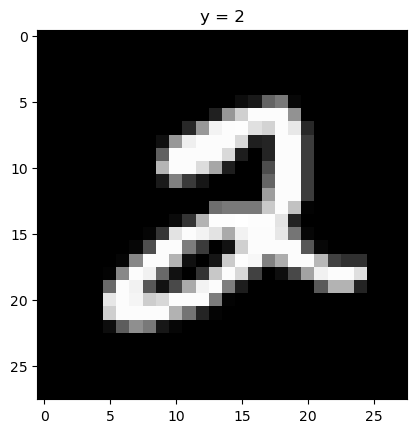

In [136]:
# Plot the image
show_data(train_dataset[5])

In [137]:
# dataloaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000)

<a name="8.3"></a>
### <font color='#2874a6'> <b> 8.3. Model </b> </font>

We will build a softmax classifier.

In [153]:
# Set input size and output size
input_size = 28 * 28 # 28x28 images
output_dim = 10 # 10 outputs, digits from 0 to 9

In [140]:
# Define the softmax classifier
class SoftmaxClassifier(nn.Module):
    
    # constructor
    def __init__(self, input_size, output_size):
        super(SoftmaxClassifier, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    # prediction
    def forward(self, x):
        # Apply the linear transformation and then apply Softmax
        logits = self.linear(x)
        return torch.softmax(logits, dim = -1)  # Apply softmax across the output dimension

In [141]:
model = SoftmaxClassifier(input_dim, output_dim)
print(f"Print the model:\n {model}")

Print the model:
 SoftmaxClassifier(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)


In [142]:
# Print the parameters
print(f"W: ,{list(model.parameters())[0].size()}")
print(f"b: ,{list(model.parameters())[1].size()}")

W: ,torch.Size([10, 784])
b: ,torch.Size([10])


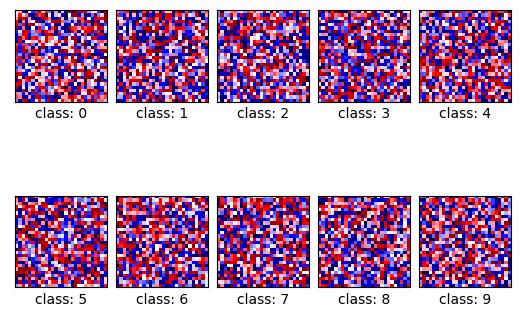

In [143]:
# Plot the model parameters for each class
plot_parameters(model)

In [144]:
# criterion
criterion = nn.CrossEntropyLoss()

In [145]:
# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)

<a name="8.4"></a>
### <font color='#2874a6'> <b> 8.4. Training </b> </font>

In [146]:
# train function
def train_model(model, train_loader, val_loader, input_size, optimizer, criterion, N_test, epochs):
    """
    Trains a machine learning model using the given training data and validates it on the validation data.

    Args:
        model (torch.nn.Module): The neural network model to be trained.
        train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
        val_loader (torch.utils.data.DataLoader): DataLoader for the validation dataset.
        input_size: Size of the images (28*28)
        optimizer (torch.optim.Optimizer): Optimizer used to update model parameters.
        criterion (torch.nn.Module): Loss function used to compute the model's loss.
        N_test (int): The total number of samples in the validation set for accuracy calculation.
        epochs (int): The number of epochs to train the model.

    Returns:
        tuple: A tuple containing:
            - model (torch.nn.Module): The trained model.
            - loss_list (list): A list of loss values recorded at each epoch.
            - accuracy_list (list): A list of accuracy values recorded at each epoch.
    """
    loss_list = []
    accuracy_list = []
    
    for epoch in range(epochs):
        # Set model to training mode
        model.train()
        
        # train
        for x, y in train_loader:
            optimizer.zero_grad()
            z = model(x.view(-1, input_size))
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            
        # Set model to evaluation mode for validation
        model.eval()
        
        # validation
        correct = 0
        with torch.no_grad():  # Disable gradient calculation during validation
            for x_test, y_test in val_loader:
                z = model(x_test.view(-1, 28*28))
                _, yhat = torch.max(z.data, 1)
                correct += (yhat == y_test).sum().item()
                
        accuracy = correct / N_test
        
        # lists
        loss_list.append(loss.data)
        accuracy_list.append(accuracy)
        
    return model, loss_list, accuracy_list


In [147]:
trained_model, loss_list, accuracy_list = train_model(model, train_loader, validation_loader, input_size, 
                                                     optimizer,
                                                     criterion, len(validation_dataset), 12)

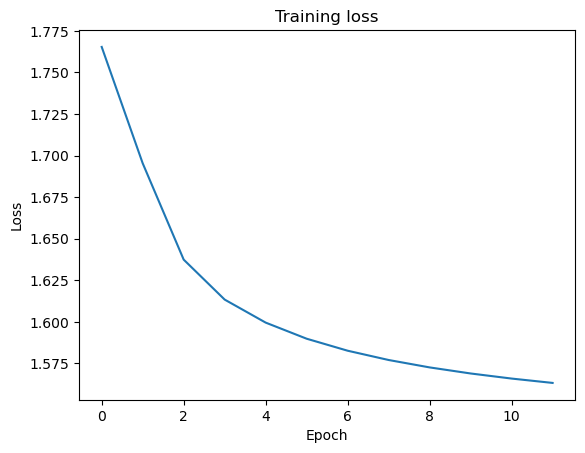

In [157]:
# plot training loss
plot_data(loss_list,'Training loss','Epoch','Loss')

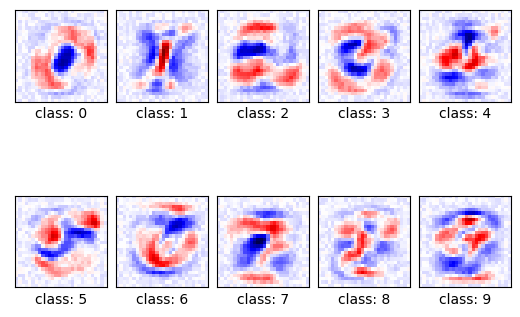

In [158]:
# Plot the model parameters for each class
plot_parameters(trained_model)

<a name="8.5"></a>
### <font color='#2874a6'> <b> 8.5. Predictions </b> </font>

In [160]:
x = validation_dataset[0][0]

In [161]:
x.shape

torch.Size([1, 28, 28])

In [162]:
aux = x.reshape(-1, 28*28)
aux.shape

torch.Size([1, 784])

In [164]:
yhat = model(x.reshape(-1, 28 * 28))
yhat, yhat.shape

(tensor([[2.1533e-03, 2.6581e-07, 1.0824e-04, 1.0728e-01, 4.7064e-08, 8.8824e-01,
          6.8201e-05, 1.8232e-03, 2.8631e-04, 3.6786e-05]],
        grad_fn=<SoftmaxBackward0>),
 torch.Size([1, 10]))

We can see that the result is a tensor with the probability for each digit.

In [165]:
# index and value of the max
torch.max(yhat, 1)

torch.return_types.max(
values=tensor([0.8882], grad_fn=<MaxBackward0>),
indices=tensor([5]))

In [166]:
torch.max(yhat, 1)[0], torch.max(yhat, 1)[1]

(tensor([0.8882], grad_fn=<MaxBackward0>), tensor([5]))

In [167]:
torch.max(yhat).item()

0.8882395625114441

<a name="8.6"></a>
### <font color='#2874a6'> <b> 8.6. Analysis </b> </font>

### Correctly classified labels

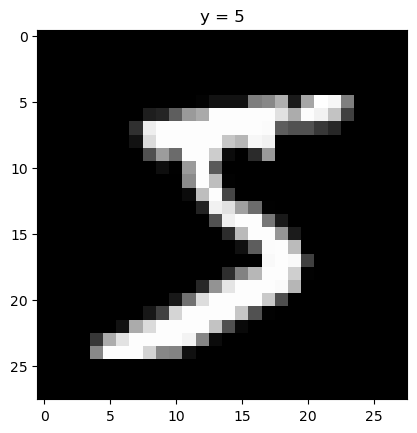

yhat: tensor([5])
Probability of class: 0.8882395625114441 


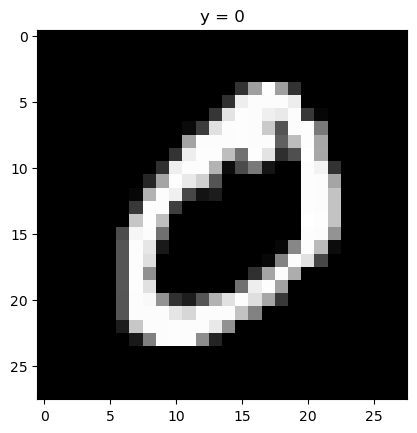

yhat: tensor([0])
Probability of class: 0.9998568296432495 


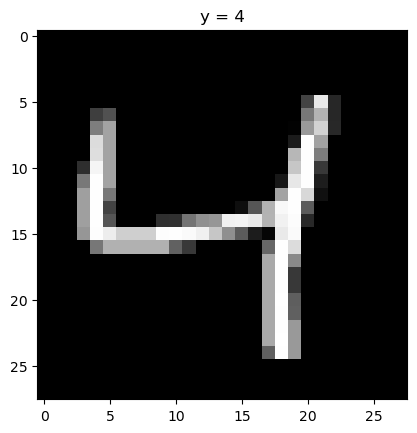

yhat: tensor([4])
Probability of class: 0.9816214442253113 


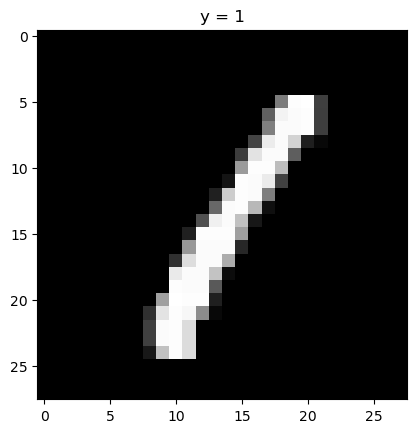

yhat: tensor([1])
Probability of class: 0.9935185313224792 


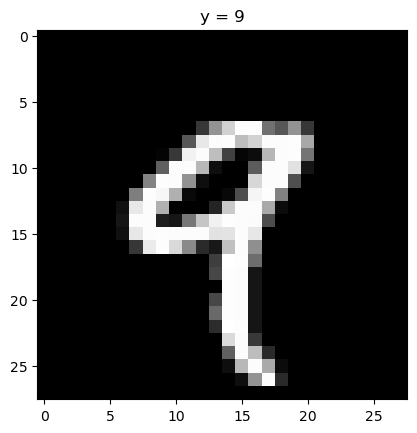

yhat: tensor([9])
Probability of class: 0.9834434986114502 


In [169]:
count = 0
for x, y in validation_dataset:
    z = model(x.reshape(-1, 28 * 28))
    prob, yhat = torch.max(z, 1)
    if yhat == y:
        show_data((x, y))
        plt.show()
        print(f"yhat: {yhat}")
        print(f"Probability of class: {prob.item()} ")
        count += 1
    if count >= 5:
        break 

### Misclassified labels

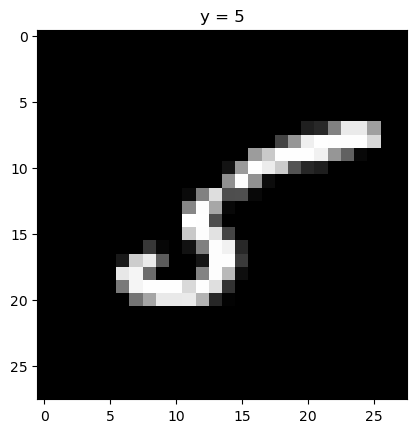

yhat: tensor([8])
Probability of class: 0.35837191343307495


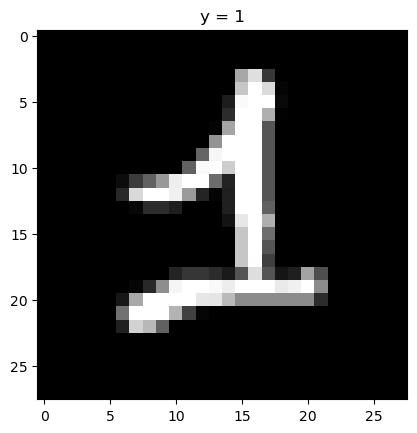

yhat: tensor([6])
Probability of class: 0.37619054317474365


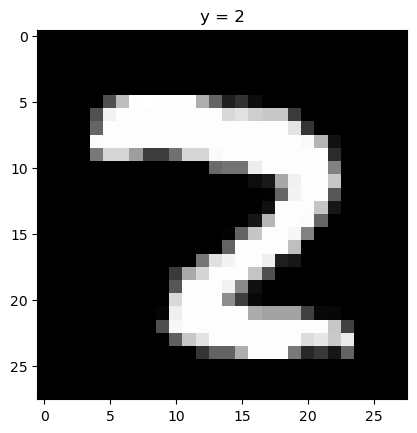

yhat: tensor([7])
Probability of class: 0.9967808723449707


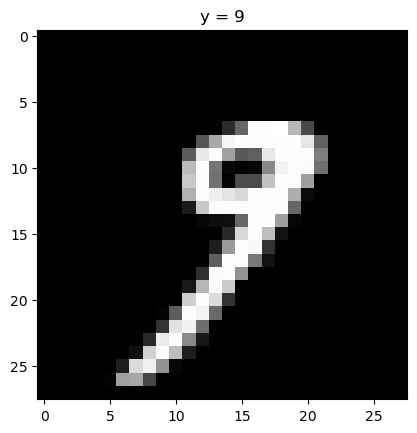

yhat: tensor([7])
Probability of class: 0.7114114761352539


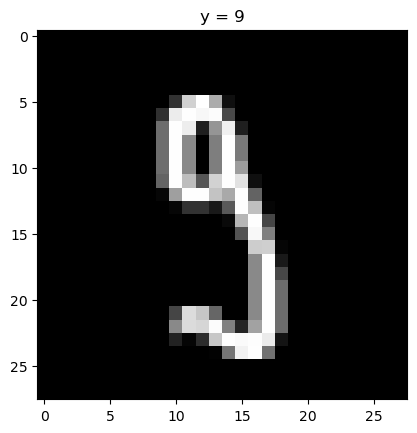

yhat: tensor([5])
Probability of class: 0.752467930316925


In [170]:
count = 0
for x, y in validation_dataset:
    z = model(x.reshape(-1, 28 * 28))
    prob, yhat = torch.max(z, 1)
    if yhat != y:
        show_data((x, y))
        plt.show()
        print(f"yhat: {yhat}")
        print(f"Probability of class: {prob.item()}")
        count += 1
    if count >= 5:
        break   

<a name="references"></a>
## <font color='blue'> <b> References </b> </font>

[IBM AI Engineering Professional Certificate](https://www.coursera.org/professional-certificates/ai-engineer)

[PyTorch Dcoumentation](https://pytorch.org/docs/stable/index.html)